# Study of perfect weights recall


In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=2.0)

In [2]:
from network import Protocol, BCPNNFast, NetworkManager
from connectivity_functions import  artificial_connectivity_matrix, create_artificial_manager
from analysis_functions import calculate_angle_from_history, calculate_winning_pattern_from_distances
from analysis_functions import calculate_patterns_timings, calculate_recall_success
from analysis_functions import calculate_recall_success_sequences
from plotting_functions import plot_weight_matrix

## An example

In [3]:
# Patterns parameters
hypercolumns = 4
minicolumns = 20

dt = 0.001

# Recall
n = 1
T_cue = 0.100
T_recall = 4.0

# Artificial matrix
beta = False
value = 3.0
inhibition = -1.0
extension = 1
decay_factor = 0.0
sequence_decay = 0.0

# Sequence structure
overlap = 3
number_of_sequences = 2
half_width = 3


# Build chain protocol
chain_protocol = Protocol()
units_to_overload = [i for i in range(overlap)]
sequences = chain_protocol.create_overload_chain(number_of_sequences, half_width, units_to_overload)

manager = create_artificial_manager(hypercolumns, minicolumns, sequences, value=value,
                                    inhibition=inhibition,
                                    extension=extension, decay_factor=decay_factor,
                                    sequence_decay=sequence_decay,
                                    dt=dt, BCPNNFast=BCPNNFast, NetworkManager=NetworkManager, ampa=True,
                                    beta=beta, values_to_save=['o', 's', 'z_pre'])

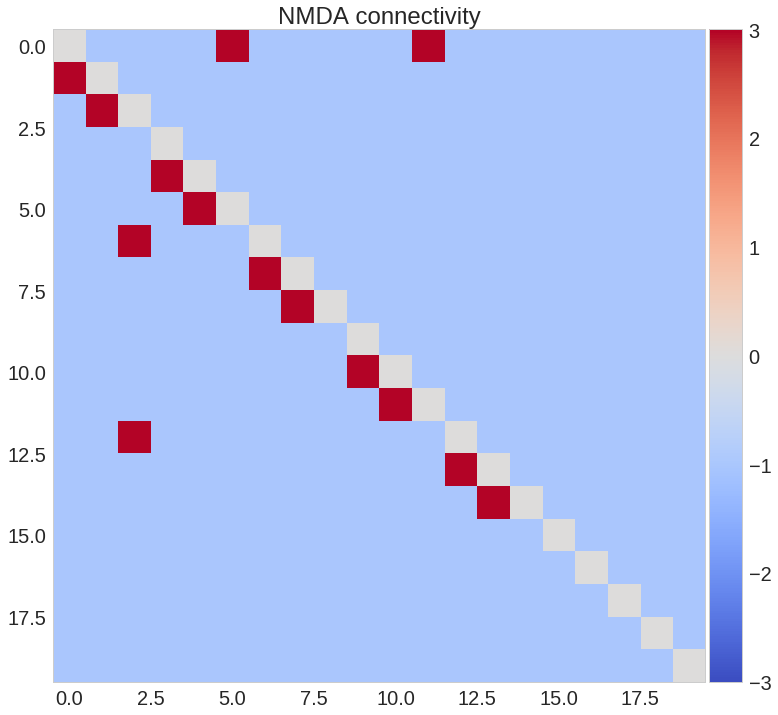

In [4]:
plot_weight_matrix(manager.nn)

In [5]:
sequences

[[3, 4, 5, 0, 1, 2, 6, 7, 8], [9, 10, 11, 0, 1, 2, 12, 13, 14]]

In [6]:
tau_z_pre = 0.150
manager.nn.tau_z_pre = tau_z_pre
manager.nn.sigma = 1.0
manager.nn.g_w = 1.0
manager.nn.G = 1.0

n = 1
successes = calculate_recall_success(manager, T_recall=T_recall, I_cue=3, T_cue=T_cue, 
                                     n=n, patterns_indexes=sequences[0])

angles = calculate_angle_from_history(manager)
winning_patterns = calculate_winning_pattern_from_distances(angles)
timings = calculate_patterns_timings(winning_patterns, manager.dt, remove=0.010)

In [7]:
timings

[(3, 0.35000000000000003, 0.0, 0.34900000000000003),
 (4, 0.35999999999999999, 0.34900000000000003, 0.70799999999999996),
 (5, 0.35899999999999999, 0.70799999999999996, 1.0660000000000001),
 (0, 0.35899999999999999, 1.0660000000000001, 1.4239999999999999),
 (1, 0.36099999999999999, 1.4239999999999999, 1.784),
 (2, 0.35299999999999998, 1.784, 2.1360000000000001),
 (6, 0.36899999999999999, 2.1470000000000002, 2.5150000000000001),
 (7, 0.35799999999999998, 2.5150000000000001, 2.8719999999999999),
 (8, 0.754, 2.8719999999999999, 3.625),
 (10, 0.072000000000000008, 3.625, 3.6960000000000002),
 (11, 0.40300000000000002, 3.6960000000000002, 4.0979999999999999)]

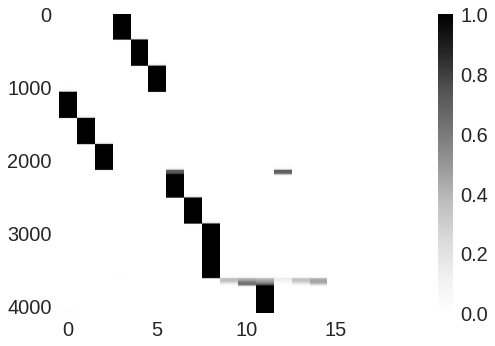

In [8]:
plt.imshow(angles, aspect='auto')
plt.grid()
plt.colorbar()

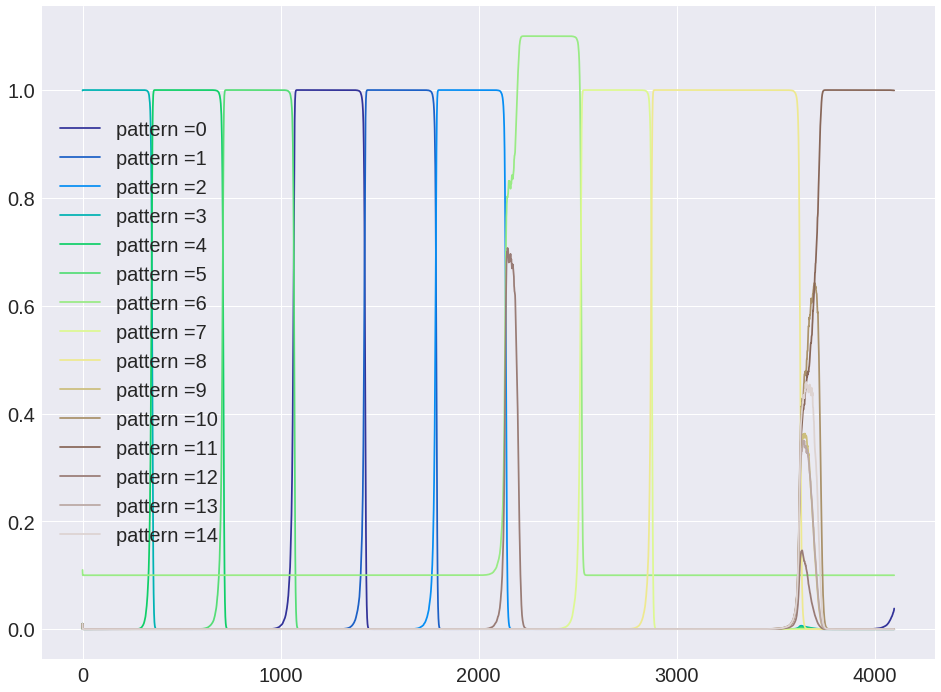

In [9]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

cmap = matplotlib.cm.terrain
norm = matplotlib.colors.Normalize(vmin=0, vmax=15)

for index, angle in enumerate(angles.T):
    if index < 15:
        if index == 6:
            ax.plot(angle + 0.1, color=cmap(norm(index)), label='pattern =' + str(index))
        else:
            ax.plot(angle, color=cmap(norm(index)), label='pattern =' + str(index))

ax.legend();

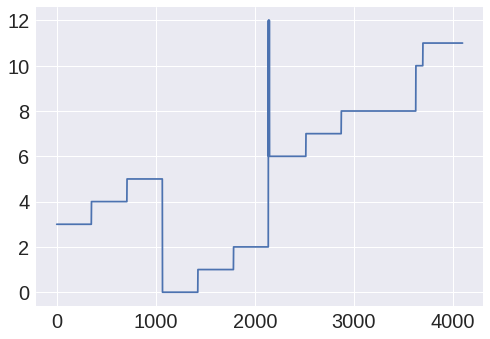

In [10]:
plt.plot(winning_patterns)

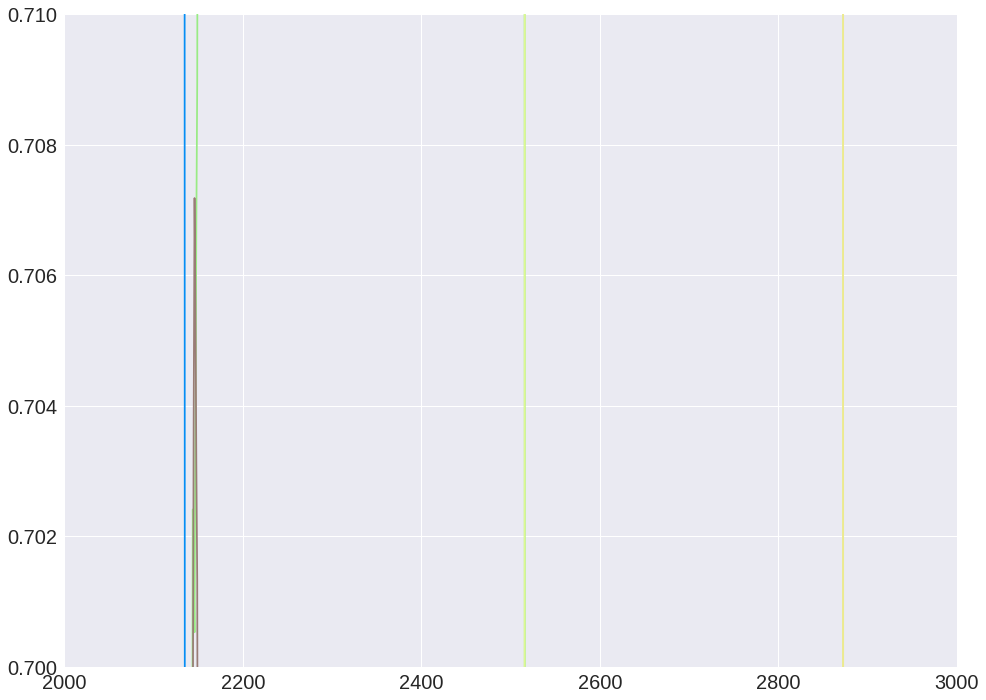

In [11]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

cmap = matplotlib.cm.terrain
norm = matplotlib.colors.Normalize(vmin=0, vmax=15)

for index, angle in enumerate(angles.T):
    if index < 15:
        ax.plot(angle, color=cmap(norm(index)), label='pattern =' + str(index))

ax.set_xlim([2000, 3000])
ax.set_ylim([0.7, 0.71]);

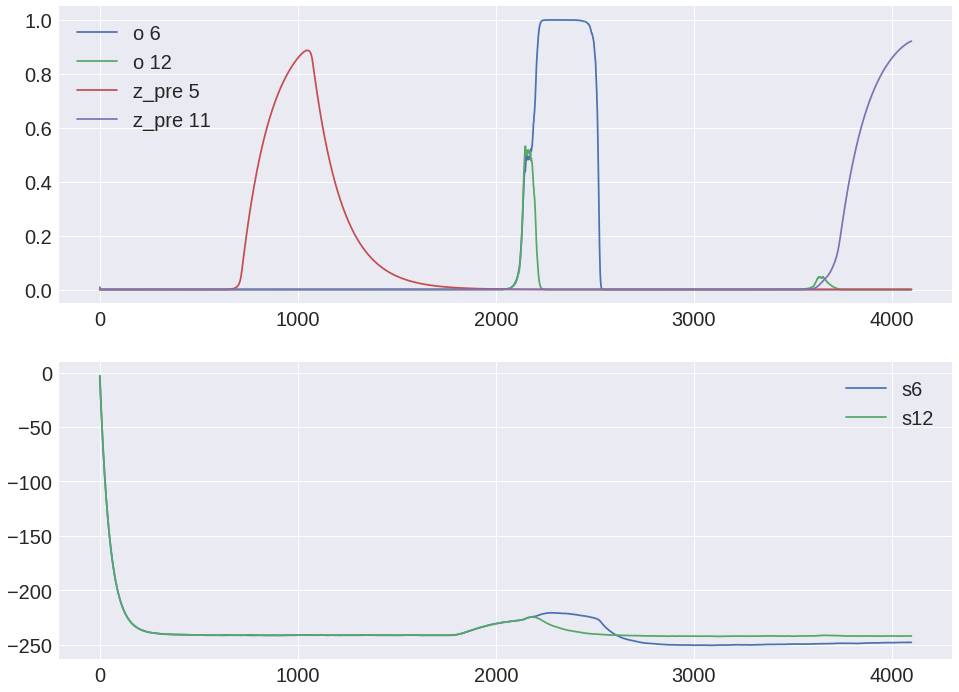

In [12]:
s = manager.history['s']
o = manager.history['o']
z_pre = manager.history['z_pre']

start = 0

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(211)
ax.plot(o[start:, 6], label='o 6')
ax.plot(o[start:, 12], label='o 12')

ax.plot(z_pre[start:, 5], label='z_pre 5')
ax.plot(z_pre[start:, 11], label='z_pre 11')

ax.legend()

ax = fig.add_subplot(212)
ax.plot(s[start:, 6], label='s6')
ax.plot(s[start:, 12], label='s12')


ax.legend()
plt.show()

In [13]:
n = 1
successes = calculate_recall_success_sequences(manager, T_recall=T_recall, T_cue=T_cue, n=n, sequences=sequences)
print(successes)

[100.0, 0.0]


## Real training

In [14]:
# Patterns parameters
hypercolumns = 4
minicolumns = 20

dt = 0.001

values_to_save = ['o', 'z_pre', 's']

# Recall
n = 10
T_cue = 0.100
T_recall = 4.0


# Protocol
training_time = 0.1
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3

# Build the network
tau_z_pre = 0.050
tau_p = 100.0

nn = BCPNNFast(hypercolumns, minicolumns, tau_z_pre=tau_z_pre, tau_p=tau_p)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the protocol for training
overlap = 3
number_of_sequences = 2
half_width = 3
units_to_overload = [i for i in range(overlap)]


In [15]:
protocol = Protocol()
units_to_overload = [i for i in range(overlap)]
sequences = protocol.create_overload_chain(number_of_sequences, half_width, units_to_overload)
sequences = [sequences[1], sequences[0]]
protocol.cross_protocol(sequences, training_time=training_time,
                        inter_sequence_interval=inter_sequence_interval, epochs=epochs)



In [16]:
manager.run_network_protocol(protocol=protocol, verbose=True, reset=True, empty_history=False)
# manager.run_network_protocol(protocol=protocol, verbose=True, reset=True, empty_history=False)
# manager.run_network_protocol(protocol=protocol, verbose=True, reset=True, empty_history=False)

('epochs', 0)
('epochs', 1)
('epochs', 2)


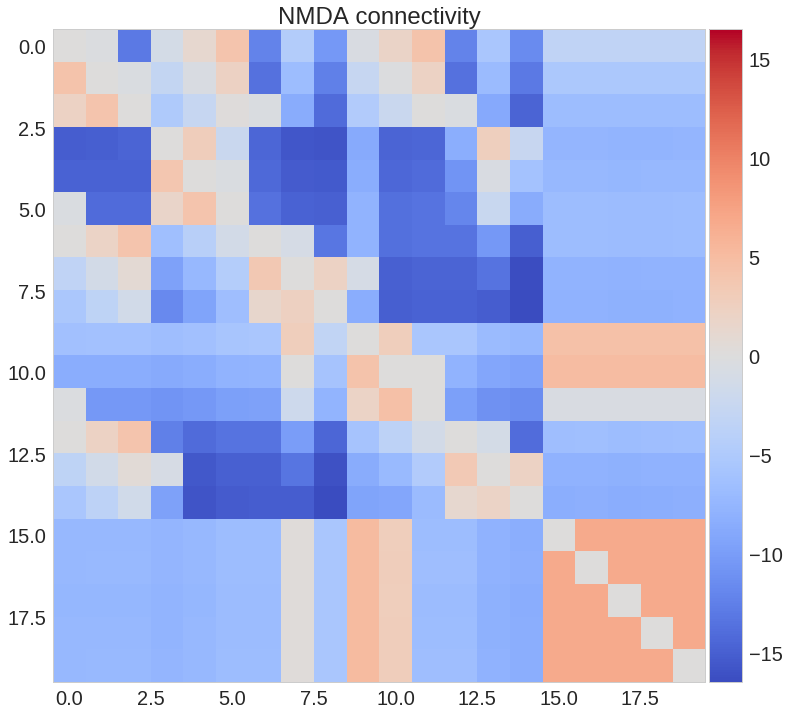

In [17]:
plot_weight_matrix(manager.nn, one_hypercolum=True)

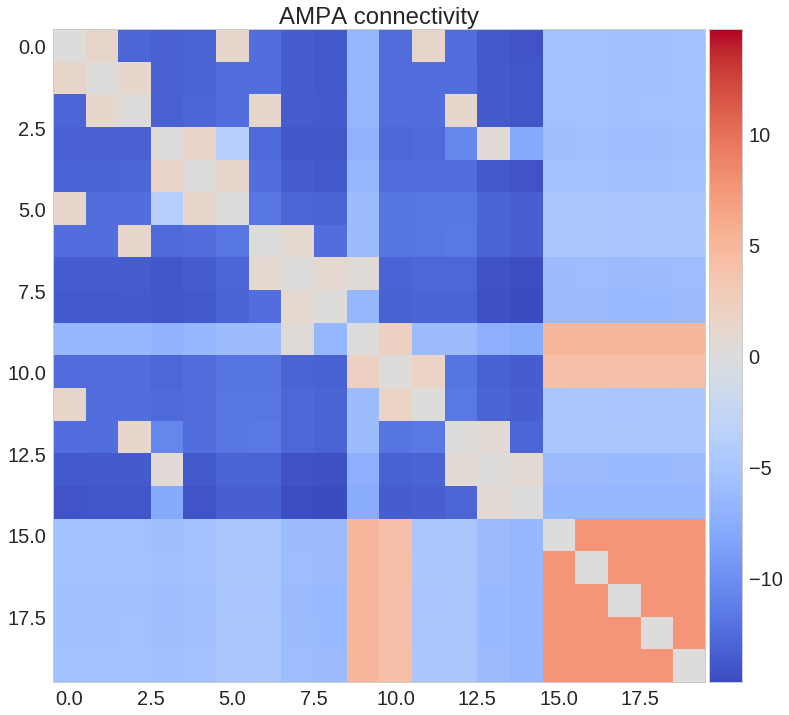

In [18]:
plot_weight_matrix(manager.nn, ampa=True, one_hypercolum=True)

In [19]:
w = nn.w

print(w[6, 5])
print(w[12, 5])
print('-----')
print(w[6, 11])
print(w[12, 11])
print('------')
print('overlap')
print(w[6, 2])
print(w[12, 2])
print('-----')
print(w[6, 1])
print(w[12, 1])
print('----')
print(w[6, 0])
print(w[12, 0])
print('----')
print(w[6, minicolumns + 6])
print(w[12, minicolumns + 12])
print('----')
print(w[1, 0]) * hypercolumns
print(w[0, minicolumns]) * (hypercolumns - 1)

-1.19413458244
-13.4890755302
-----
-13.4992203
-1.27331037223
------
overlap
4.0730755932
4.06219368438
-----
2.01333882479
2.06532522933
----
0.0218103927219
0.0928011649221
----
5.33648051238
5.34742620905
----
16.5097166644
14.0730309626


In [20]:
sequences

[[9, 10, 11, 0, 1, 2, 12, 13, 14], [3, 4, 5, 0, 1, 2, 6, 7, 8]]

In [21]:
tau_z_pre = 0.050
manager.nn.tau_z_pre = tau_z_pre
manager.nn.sigma = 0.0
manager.nn.g_w = 5.0
manager.nn.g_w_ampa = 1.0
manager.nn.G = 1.0

if True:
    for i in range(3):
        for k in range(hypercolumns):
            index_1 = k * minicolumns
            print('------')
            print(index_1)
            print('-------')
            for l in range(hypercolumns):
                
                index_2 = l * minicolumns
                print(index_2)
                if True:
                    aux1 = nn.w[6 + index_1, i + index_2]
                    aux2 = nn.w[12 + index_1, i + index_2]

                    nn.w[12 + index_1, i + index_2] = aux1
                    nn.w[6 + index_1, i + index_2] = aux2
                
                if True:
                    aux1 = nn.w_ampa[6 + index_1, i + index_2]
                    aux2 = nn.w_ampa[12 + index_1, i + index_2]

                    nn.w_ampa[12 + index_1, i + index_2] = aux1
                    nn.w_ampa[6 + index_1, i + index_2] = aux2

        # nn.w[12, 2] = nn.w[6, 2]
        #nn.w[12, 1] = nn.w[6, 1]
        # nn.w[12, 0] = nn.w[6, 0]

n = 1
T_recall = 3.0
successes = calculate_recall_success(manager, T_recall=T_recall, I_cue=3, T_cue=T_cue, 
                                     n=n, patterns_indexes=sequences[0])

angles = calculate_angle_from_history(manager)
winning_patterns = calculate_winning_pattern_from_distances(angles)
timings = calculate_patterns_timings(winning_patterns, manager.dt, remove=0.010)

------
0
-------
0
20
40
60
------
20
-------
0
20
40
60
------
40
-------
0
20
40
60
------
60
-------
0
20
40
60
------
0
-------
0
20
40
60
------
20
-------
0
20
40
60
------
40
-------
0
20
40
60
------
60
-------
0
20
40
60
------
0
-------
0
20
40
60
------
20
-------
0
20
40
60
------
40
-------
0
20
40
60
------
60
-------
0
20
40
60


In [22]:
timings

[(3, 0.26400000000000001, 0.0, 0.26300000000000001),
 (4, 0.188, 0.26300000000000001, 0.45000000000000001),
 (5, 0.314, 0.45000000000000001, 0.76300000000000001),
 (0, 0.17500000000000002, 0.76300000000000001, 0.93700000000000006),
 (1, 0.182, 0.93700000000000006, 1.1180000000000001),
 (2, 0.23300000000000001, 1.1180000000000001, 1.3500000000000001),
 (6, 0.65800000000000003, 1.3500000000000001, 2.0070000000000001),
 (7, 0.68300000000000005, 2.0070000000000001, 2.6890000000000001),
 (9, 0.17100000000000001, 2.6890000000000001, 2.859),
 (10, 0.23999999999999999, 2.859, 3.0979999999999999)]

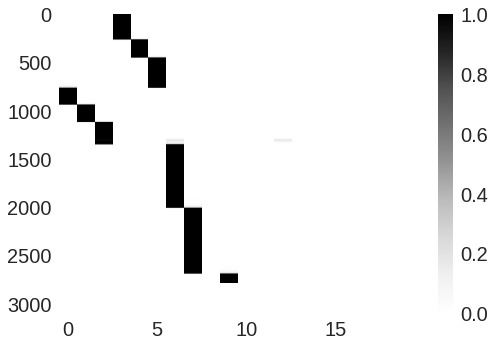

In [23]:
plt.imshow(angles, aspect='auto')
plt.grid()
plt.colorbar()

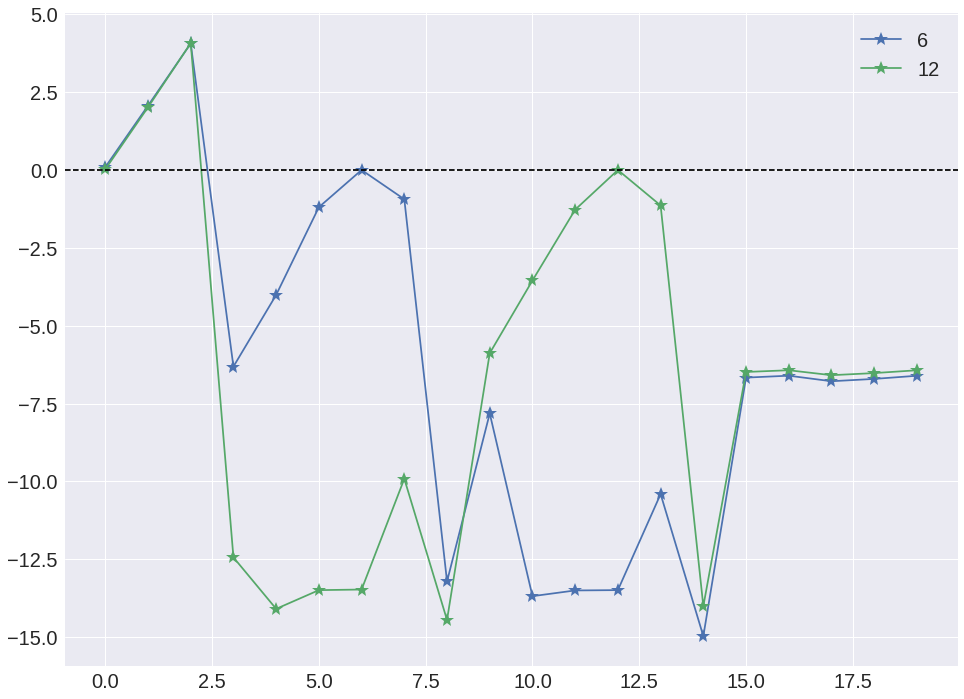

In [24]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(nn.w[6, :minicolumns], '*-', markersize=15, label='6')
ax.plot(nn.w[12, :minicolumns:], '*-', markersize=15, label='12')


if False:
    ax.plot(nn.w[6, minicolumns:2 * minicolumns], '*-', markersize=15, label='6')
    ax.plot(nn.w[12, minicolumns:2 * minicolumns], '*-', markersize=15, label='12')

ax.axhline(0, ls='--', color='black')
ax.legend();

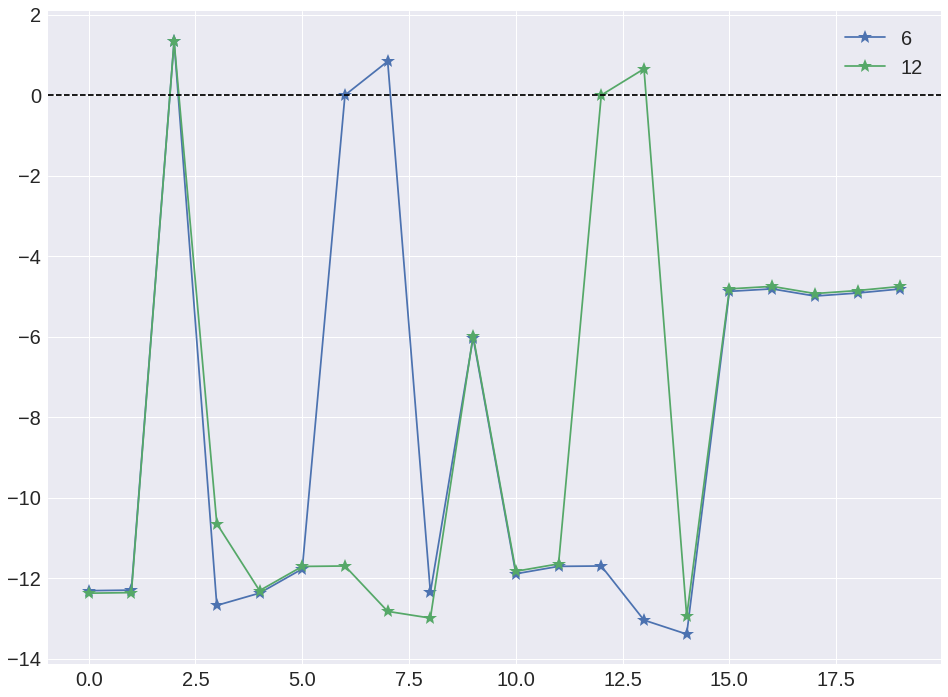

In [25]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(nn.w_ampa[6, :minicolumns], '*-', markersize=15, label='6')
ax.plot(nn.w_ampa[12, :minicolumns:], '*-', markersize=15, label='12')

if False:
    ax.plot(nn.w_ampa[6, minicolumns:2 * minicolumns], '*-', markersize=15, label='6')
    ax.plot(nn.w_ampa[12, minicolumns:2 * minicolumns], '*-', markersize=15, label='12')

ax.axhline(0, ls='--', color='black')
ax.legend();

In [26]:


# swap(w[6, 5] - w[12, 5])
# swap(w[6, 11] = w[12, 11])

# aux1 = w[12, 5]
# aux2 = w[12, 11]

# w[12, 5] = w[6, 5]
# w[12, 11] = w[6, 11]

# w[6, 5] = aux1
# w[6, 11] = aux2


for i in range(3):
    for k in range(hypercolumns):
        index_1 = k * minicolumns
        for l in range(hypercolumns):

            index_2 = l * minicolumns
            if True:
                aux1 = nn.w[6 + index_1, i + index_2]

                nn.w[12 + index_1, i + index_2] = aux1
                nn.w[6 + index_1, i + index_2] = aux1

            if True:
                aux1 = nn.w_ampa[6 + index_1, i + index_2]

                nn.w_ampa[12 + index_1, i + index_2] = aux1
                nn.w_ampa[6 + index_1, i + index_2] = aux1


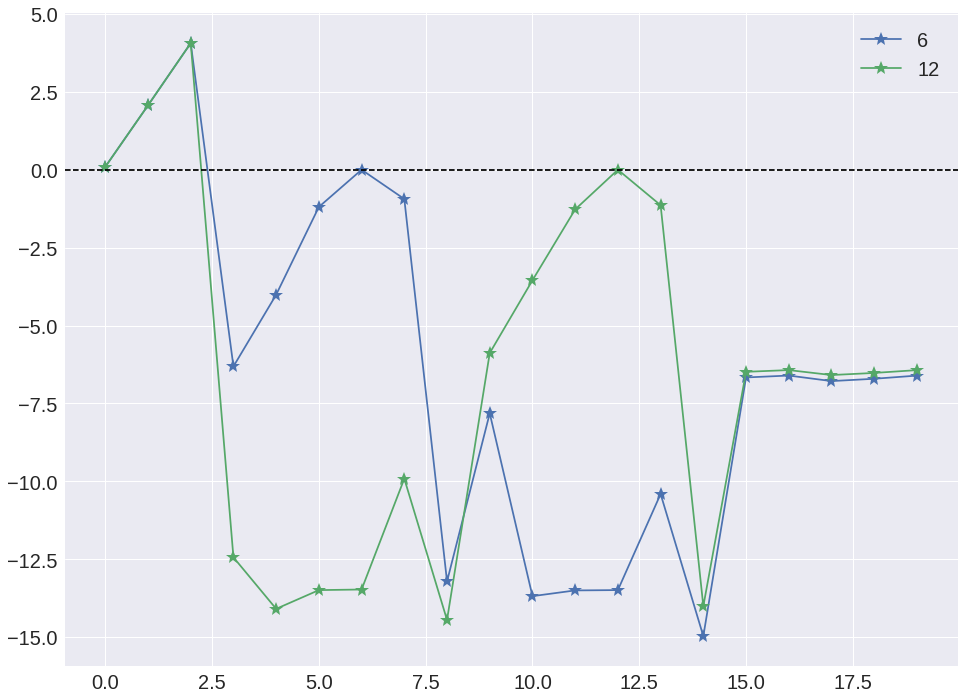

In [27]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(nn.w[6, :minicolumns], '*-', markersize=15, label='6')
ax.plot(nn.w[12, :minicolumns:], '*-', markersize=15, label='12')


if False:
    ax.plot(nn.w[6, minicolumns:2 * minicolumns], '*-', markersize=15, label='6')
    ax.plot(nn.w[12, minicolumns:2 * minicolumns], '*-', markersize=15, label='12')

ax.axhline(0, ls='--', color='black')
ax.legend();

In [28]:
tau_z_pre = 0.050
manager.nn.tau_z_pre = tau_z_pre
manager.nn.sigma = 0.0
manager.nn.g_w = 5.0
manager.nn.g_w_ampa = 1.0
manager.nn.G = 1.0

n = 1
T_recall = 3.0
successes = calculate_recall_success(manager, T_recall=T_recall, I_cue=3, T_cue=T_cue, 
                                     n=n, patterns_indexes=sequences[0])

angles = calculate_angle_from_history(manager)
winning_patterns = calculate_winning_pattern_from_distances(angles)
timings = calculate_patterns_timings(winning_patterns, manager.dt, remove=0.010)

In [29]:
timings

[(3, 0.26400000000000001, 0.0, 0.26300000000000001),
 (4, 0.188, 0.26300000000000001, 0.45000000000000001),
 (5, 0.314, 0.45000000000000001, 0.76300000000000001),
 (0, 0.17500000000000002, 0.76300000000000001, 0.93700000000000006),
 (1, 0.182, 0.93700000000000006, 1.1180000000000001),
 (2, 0.20200000000000001, 1.1180000000000001, 1.319),
 (6, 0.66100000000000003, 1.319, 1.9790000000000001),
 (7, 0.68300000000000005, 1.9790000000000001, 2.661),
 (9, 0.17100000000000001, 2.661, 2.831),
 (10, 0.26800000000000002, 2.831, 3.0979999999999999)]

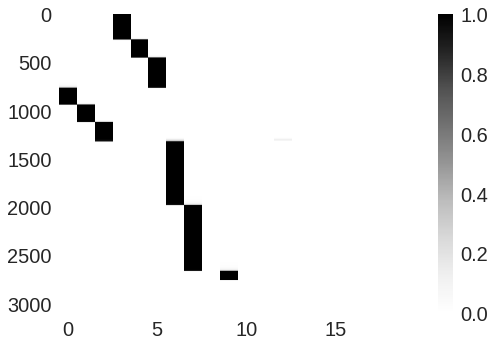

In [30]:
plt.imshow(angles, aspect='auto')
plt.grid()
plt.colorbar()

In [31]:
sequences

[[9, 10, 11, 0, 1, 2, 12, 13, 14], [3, 4, 5, 0, 1, 2, 6, 7, 8]]

In [32]:
past_list = [(5, 11), (4, 10), (3, 9)]

for past1, past2 in past_list:
    for k in range(hypercolumns):
        index_1 = k * minicolumns
        for l in range(hypercolumns):

            index_2 = l * minicolumns
            if False:
                aux1 = nn.w[12 + index_1, past1 + index_2]
                aux2 = nn.w[12 + index_1, past2 + index_2]

                nn.w[12 + index_1, past1 + index_1] = nn.w[6 + index_1, past1 + index_2]
                nn.w[12 + index_1, past2 + index_1] = nn.w[6 + index_1, past2 + index_2]

                nn.w[6 + index_1, past1 + index_2] = aux1
                nn.w[6 + index_1, past2 + index_2] = aux2
            
            if True:
                aux1 = nn.w_ampa[12 + index_1, past1 + index_2]
                aux2 = nn.w_ampa[12 + index_1, past2 + index_2]

                nn.w_ampa[12 + index_1, past1 + index_1] = nn.w_ampa[6 + index_1, past1 + index_2]
                nn.w_ampa[12 + index_1, past2 + index_1] = nn.w_ampa[6 + index_1, past2 + index_2]

                nn.w_ampa[6 + index_1, past1 + index_2] = aux1
                nn.w_ampa[6 + index_1, past2 + index_2] = aux2   

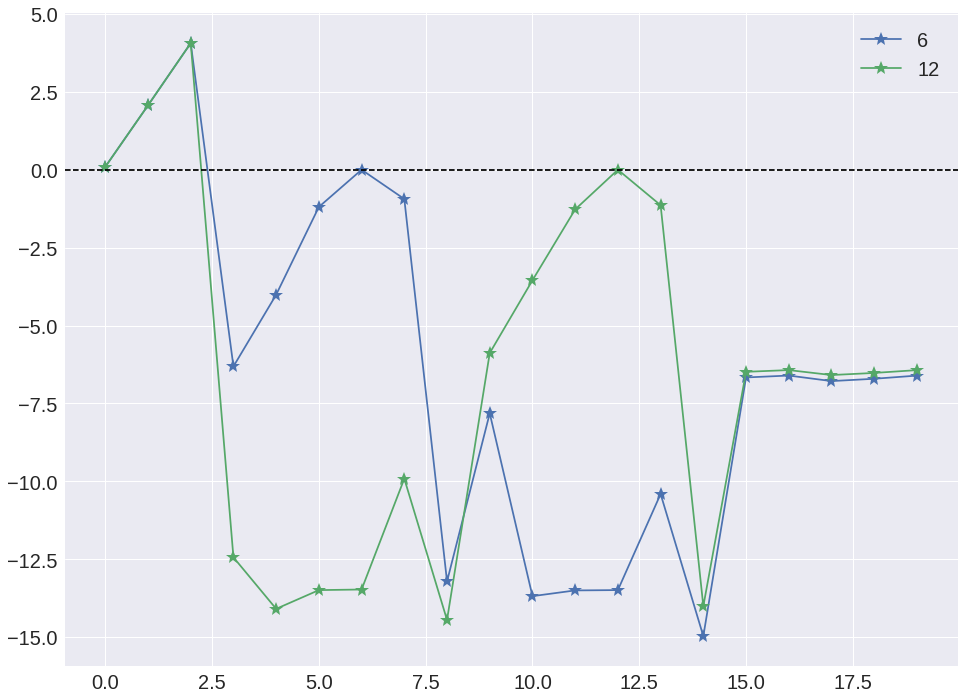

In [33]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(nn.w[6, :minicolumns], '*-', markersize=15, label='6')
ax.plot(nn.w[12, :minicolumns:], '*-', markersize=15, label='12')


if False:
    ax.plot(nn.w[6, minicolumns:2 * minicolumns], '*-', markersize=15, label='6')
    ax.plot(nn.w[12, minicolumns:2 * minicolumns], '*-', markersize=15, label='12')

ax.axhline(0, ls='--', color='black')
ax.legend();

In [34]:
tau_z_pre = 0.250
manager.nn.tau_z_pre = tau_z_pre
manager.nn.sigma = 0.0
manager.nn.g_w = 5.0
manager.nn.g_w_ampa = 1.0
manager.nn.G = 1.0

n = 1
T_recall = 3.0
successes = calculate_recall_success(manager, T_recall=T_recall, I_cue=3, T_cue=T_cue, 
                                     n=n, patterns_indexes=sequences[0])

angles = calculate_angle_from_history(manager)
winning_patterns = calculate_winning_pattern_from_distances(angles)
timings = calculate_patterns_timings(winning_patterns, manager.dt, remove=0.010)

In [35]:
timings

[(3, 0.28000000000000003, 0.0, 0.27900000000000003),
 (4, 0.35100000000000003, 0.27900000000000003, 0.629),
 (5, 0.54300000000000004, 0.629, 1.171),
 (0, 0.36099999999999999, 1.171, 1.5310000000000001),
 (1, 0.379, 1.5310000000000001, 1.909),
 (2, 0.38, 1.909, 2.2880000000000003),
 (6, 0.79600000000000004, 2.2880000000000003, 3.0830000000000002),
 (7, 0.016, 3.0830000000000002, 3.0979999999999999)]

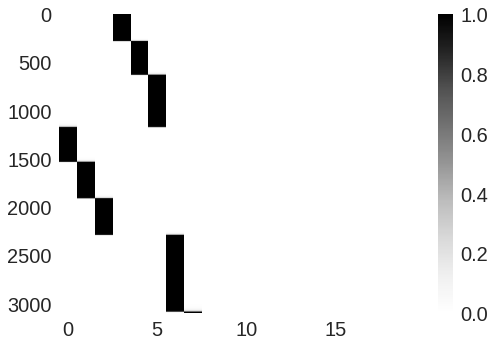

In [36]:
plt.imshow(angles, aspect='auto')
plt.grid()
plt.colorbar()

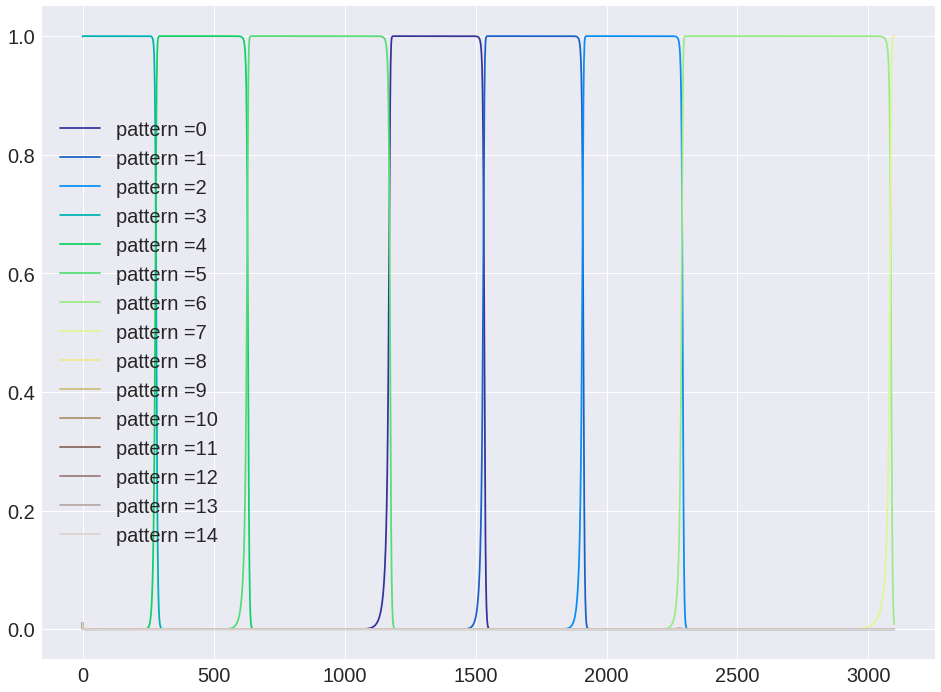

In [37]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

cmap = matplotlib.cm.terrain
norm = matplotlib.colors.Normalize(vmin=0, vmax=15)

for index, angle in enumerate(angles.T):
    if index < 15:
        if index == 6:
            ax.plot(angle, color=cmap(norm(index)), label='pattern =' + str(index))
        else:
            ax.plot(angle, color=cmap(norm(index)), label='pattern =' + str(index))

ax.legend();

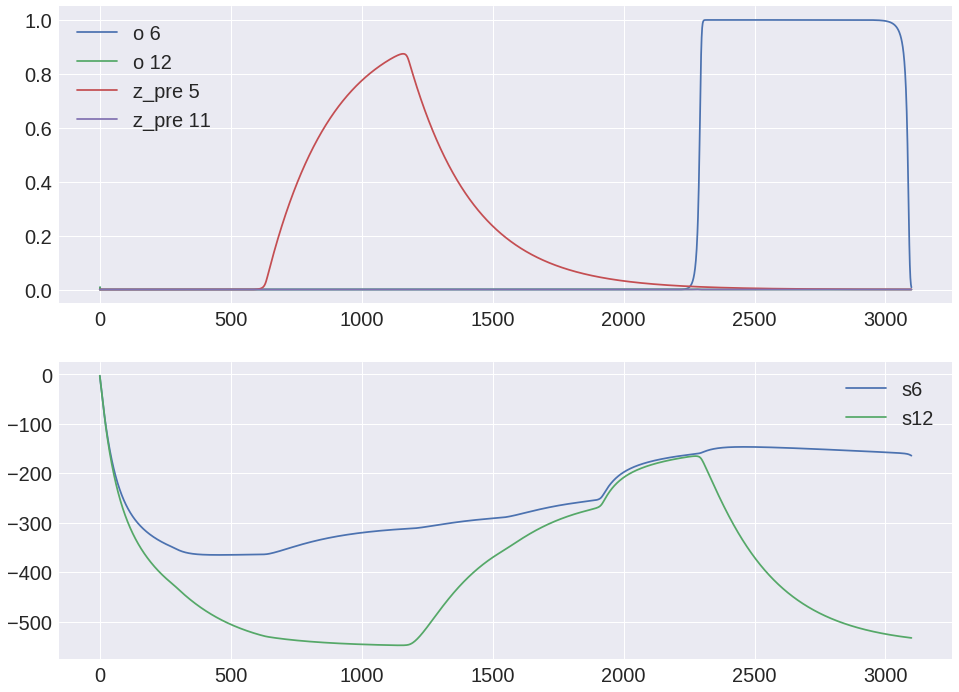

In [38]:
s = manager.history['s']
o = manager.history['o']
z_pre = manager.history['z_pre']

start = 0

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(211)
ax.plot(o[start:, 6], label='o 6')
ax.plot(o[start:, 12], label='o 12')

ax.plot(z_pre[start:, 5], label='z_pre 5')
ax.plot(z_pre[start:, 11], label='z_pre 11')

ax.legend()

ax = fig.add_subplot(212)
ax.plot(s[start:, 6], label='s6')
ax.plot(s[start:, 12], label='s12')


ax.legend()
plt.show()

In [39]:
n = 20
manager.nn_w_ampa = 0.0
manager.nn.tau_z_pre = 0.010
successes = calculate_recall_success_sequences(manager, T_recall=T_recall, T_cue=T_cue, n=n, sequences=sequences)


In [40]:
successes

[0.0, 0.0]